# E01. Evaluate Games
- This evaluates game projections
- Type: Evaluation
- Run Frequency: Irregular
- Sources:
    - Sportsbook Review
- Created: 3/30/2024
- Updated: 7/15/2025

### Imports

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U01. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U02. Functions.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U03. Classes.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U04. Datasets.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U05. Models.ipynb"

### Settings

In [2]:
start_date, end_date = "20240101", "20240527"
# start_date, end_date = "20240101", "20240524"
# start_date, end_date = todaysdate, todaysdate

### Data

##### Games

Read in games from MLB API

In [3]:
# %%time
# historic_game_df = pd.read_csv(os.path.join(baseball_path, "game_df.csv"))
# recent_game_df = create_games(yesterdaysdate, todaysdate, team_dict)
# historic_game_df = historic_game_df[~historic_game_df['date'].astype(str).isin([yesterdaysdate, todaysdate])]
# all_game_df = pd.concat([historic_game_df, recent_game_df], axis=0)
# all_game_df.to_csv(os.path.join(baseball_path, "game_df.csv"), index=False)

In [4]:
%%time
all_game_df = pd.read_csv(os.path.join(baseball_path, "game_df.csv"))

CPU times: total: 62.5 ms
Wall time: 65.4 ms


In [5]:
game_df = all_game_df[(all_game_df['date'].astype(str) >= start_date) & (all_game_df['date'].astype(str) <= end_date)].reset_index(drop=True)

In [6]:
game_df['date'] = game_df['date'].astype(int)

##### Odds

Read in game odds from Sportsbook Review

In [7]:
odds_df_list = []
# Read in odds
for date in game_df['date'].unique():
    odds_df = pd.read_csv(os.path.join(baseball_path, "A08. Odds Sportsbook Review", f"Odds {date}.csv"))
    odds_df_list.append(odds_df)

odds_df = pd.concat(odds_df_list, axis=0, ignore_index=True)

Determine game number (in case of double headers)

In [8]:
odds_df['game_num'] = odds_df.groupby(['HomeTeamShort', 'date']).cumcount()+1

Use standardized team abbreviations

In [9]:
odds_df['away_team'] = odds_df['VisitorTeamShort'].map(team_dict)
odds_df['home_team'] = odds_df['HomeTeamShort'].map(team_dict)

##### Merge

Merge gambling data onto game data

In [10]:
game_df_column_list = ['game_id', 'game_datetime', 'date', 'game_type', 'status', 'venue_id', 'venue_name', 'away_team', 'home_team', 'game_num', 'away_score', 'home_score']

In [11]:
odds_df = pd.merge(game_df[game_df_column_list], odds_df, on=['date', 'game_num', 'away_team', 'home_team'], how='left')

##### Sims

Calculate model gambling expectations

In [12]:
def process_sims(game_id, date, Spread, OU):
    try:
        df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", f"Matchups {date}", f"game_{game_id}.csv"))
    except FileNotFoundError:
        return pd.Series()  # empty to signal skip

    ### Spread
    df['Spread'] = Spread
    df['SpreadCover1'] = (df['away_score'] > df['home_score'] + df['Spread']).astype(int)
    df['SpreadCover2'] = (df['away_score'] < df['home_score'] + df['Spread']).astype(int)
    df['SpreadCover3'] = (df['away_score'] == df['home_score'] + df['Spread']).astype(int)  

    ### Over/Under
    df['OU'] = OU
    df['OuCover1'] = (df['away_score'] + df['home_score'] > df['OU']).astype(int)
    df['OuCover2'] = (df['away_score'] + df['home_score'] < df['OU']).astype(int)
    df['OuCover3'] = (df['away_score'] + df['home_score'] == df['OU']).astype(int)

    ### ML
    df['MLCover1'] = (df['away_score'] > df['home_score']).astype(int)
    df['MLCover2'] = (df['away_score'] < df['home_score']).astype(int)

    ### Victory Margin
    df['Margin'] = abs(df['away_score'] - df['home_score'])

    # Rename to avoid compatibility issues with actual scores
    df.rename(columns={'away_score': 'ModelScore1',
                       'home_score': 'ModelScore2'}, inplace=True)

    means = df[['ModelScore1', 'ModelScore2', 
                'SpreadCover1', 'SpreadCover2', 'SpreadCover3', 
                'OuCover1', 'OuCover2', 'OuCover3', 
                'MLCover1', 'MLCover2']].mean()

    away_counts = dict(Counter(df['ModelScore1']))
    home_counts = dict(Counter(df['ModelScore2']))
    total_counts = dict(Counter(df['ModelScore1'] + df['ModelScore2']))
    margin_counts = dict(Counter(df['Margin']))

    result = pd.concat([means, pd.Series({
        'MLCounts1': away_counts,
        'MLCounts2': home_counts,
        'MLCounts3': total_counts,
        'MarginCounts': margin_counts
    })])


    return result

Run safely in parallel

In [13]:
def safe_process_row(row):
    try:
        return process_sims(row['game_id'], row['date'], row['Spread'], row['OU'])
    except FileNotFoundError:
        return pd.Series({
            'ModelScore1': np.nan,
            'ModelScore2': np.nan,
            'SpreadCover1': np.nan,
            'SpreadCover2': np.nan,
            'SpreadCover3': np.nan,
            'OuCover1': np.nan,
            'OuCover2': np.nan,
            'OuCover3': np.nan,
            'MLCover1': np.nan,
            'MLCover2': np.nan,
            'MLCounts1': {},
            'MLCounts2': {},
            'MLCounts3': {},
            'MarginCounts': {}
        })

Run

In [14]:
results_df = odds_df.apply(safe_process_row, axis=1)
odds_df = pd.concat([odds_df, results_df], axis=1)

### Clean

Convert American odds to payout multipliers

In [15]:
def multipliers(odds):
    if odds == 0:
        return np.nan
    
    elif odds > 0:
        mult = odds / 100 + 1
    else: 
        mult = 100 / odds * - 1 + 1
        
    return mult

Determine odds

In [16]:
for bet in ['Spread', 'Ou', 'ML']:
    odds_df[f'{bet}Multiplier1'] = odds_df[f'{bet}Money1'].apply(multipliers)
    odds_df[f'{bet}Multiplier2'] = odds_df[f'{bet}Money2'].apply(multipliers)
    
    odds_df[f'{bet}VegasOdds1TempA'] = 1 / odds_df[f'{bet}Multiplier1'] 
    odds_df[f'{bet}VegasOdds1TempB'] = 1 - (1 / odds_df[f'{bet}Multiplier2'])
    odds_df[f'{bet}VegasOdds1'] = odds_df[[f'{bet}VegasOdds1TempA', f'{bet}VegasOdds1TempB']].mean(axis=1)
    odds_df[f'{bet}VegasOdds2'] = 1 - odds_df[f'{bet}VegasOdds1']

Determine Vegas Dog

In [17]:
odds_df[f'MLVegasDog1'] = np.select(
    [
        odds_df['MLVegasOdds1'] > 0.5,
        odds_df['MLVegasOdds1'] < 0.5
    ],
    [
        "Favorite",
        "Underdog"
    ],
    default="Neither"
)

odds_df[f'MLVegasDog2'] = np.select(
    [
        odds_df['MLVegasOdds2'] > 0.5,
        odds_df['MLVegasOdds2'] < 0.5
    ],
    [
        "Favorite",
        "Underdog"
    ],
    default="Neither"
)

Determine Model Dog

In [18]:
odds_df[f'MLModelDog1'] = np.select(
    [
        odds_df['MLCover1'] > 0.5,
        odds_df['MLCover1'] < 0.5
    ],
    [
        "Favorite",
        "Underdog"
    ],
    default="Neither"
)

odds_df[f'MLModelDog2'] = np.select(
    [
        odds_df['MLCover2'] > 0.5,
        odds_df['MLCover2'] < 0.5
    ],
    [
        "Favorite",
        "Underdog"
    ],
    default="Neither"
)

Overwrite Spread favorite to reflect who is favorited in the game, not against the spread

In [19]:
odds_df['SpreadVegasDog1'] = odds_df['MLVegasDog1']
odds_df['SpreadVegasDog2'] = odds_df['MLVegasDog2']

odds_df['SpreadModelDog1'] = odds_df['MLModelDog1']
odds_df['SpreadModelDog2'] = odds_df['MLModelDog2']

Impute Vegas runs

Methodology:
- Calculate win probabilities using ML payouts
- Assign runs from O/U using win probability

Limitations:
- Using win probability to assign runs is imperfect
- Ignores different payouts for overs and unders

In [20]:
odds_df['VegasScore1'] = odds_df['OU'] * odds_df['MLVegasOdds1'] * (9/17.5/0.5)
odds_df['VegasScore2'] = odds_df['OU'] * odds_df['MLVegasOdds2'] * (8.5/17.5/0.5)

Convert to long

In [21]:
prefixes = ['Spread', 'Ou', 'ML']
suffixes = ['1', '2']
pattern = re.compile(rf"^({'|'.join(prefixes)})([A-Za-z0-9_]+)({'|'.join(suffixes)})$")

bet_columns = [col for col in odds_df.columns if pattern.match(col)]
game_columns = [col for col in odds_df.columns if col not in bet_columns]

# List of known dict-type columns
unhashable_cols = ['MLCounts1', 'MLCounts2', 'MLCounts3', 'MarginCounts']

# Convert dicts to strings only if they are actually dicts
for col in unhashable_cols:
    if col in odds_df.columns:
        odds_df[col] = odds_df[col].apply(lambda x: str(x) if isinstance(x, dict) else x)

# Melt the DataFrame
df_long = odds_df.melt(id_vars=game_columns, value_vars=bet_columns,
                       var_name='original_column', value_name='value')

df_long[['BetType', 'field', 'side']] = df_long['original_column'].str.extract(pattern)

# Pivot back to one row per bet
bet_df = df_long.pivot(index=game_columns + ['BetType', 'side'], columns='field', values='value').reset_index()
bet_df.columns.name = None

# Convert strings back to dicts safely
def safe_literal_eval(val):
    if isinstance(val, str) and val.strip().startswith('{'):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return val
    return val

for col in unhashable_cols:
    if col in bet_df.columns:
        bet_df[col] = bet_df[col].apply(safe_literal_eval)

Determine bet side (away/home, over/under)

In [22]:
# Define conditions
cond_ou = bet_df['BetType'] == 'Ou'
cond_1 = bet_df['side'] == '1'
cond_2 = bet_df['side'] == '2'

# Apply logic
bet_df['BetSide'] = np.select(
    [cond_ou & cond_1, cond_ou & cond_2, cond_1, cond_2],
    ['Over', 'Under', 'Away', 'Home'],
    default=None
)

bet_df.drop(columns={'side'}, inplace=True)

Determine scores

In [23]:
bet_df['Score'] = np.select(
    [
        bet_df['BetSide'] == "Away",
        bet_df['BetSide'] == "Home"
    ],
    [
        bet_df['away_score'],
        bet_df['home_score']
    ],
    default=np.nan
)

bet_df['VegasScore'] = np.select(
    [
        bet_df['BetSide'] == "Away",
        bet_df['BetSide'] == "Home"
    ],
    [
        bet_df['VegasScore1'],
        bet_df['VegasScore2']
    ],
    default=np.nan
)

bet_df['ModelScore'] = np.select(
    [
        bet_df['BetSide'] == "Away",
        bet_df['BetSide'] == "Home"
    ],
    [
        bet_df['ModelScore1'],
        bet_df['ModelScore2']
    ],
    default=np.nan
)

Determine expected payout

In [24]:
bet_df['ExpectedPayout'] = bet_df['Cover'] * bet_df['Multiplier'] 

for bet in ['Spread', 'Ou']:
    mask = bet_df['BetType'] == bet
    bet_df.loc[mask, 'ExpectedPayout'] += bet_df.loc[mask, f'{bet}Cover3']

bet_df['PositiveEV'] = (bet_df['ExpectedPayout'] > 1).astype(int)

Determine actual result

In [25]:
# Pre-calc total and spread difference
total_score = bet_df['away_score'] + bet_df['home_score']
spread_diff = bet_df['away_score'] - bet_df['home_score']

def determine_result(row):
    bet_type = row['BetType']
    side = row['BetSide']
    away = row['away_score']
    home = row['home_score']
    ou = row['OU']
    spread = row['Spread']

    if bet_type == 'ML':
        if side == 'Away':
            return 'Win' if away > home else 'Loss'
        elif side == 'Home':
            return 'Win' if home > away else 'Loss'

    elif bet_type == 'Ou':
        if total_score.loc[row.name] == ou:
            return 'Push'
        elif side == 'Over':
            return 'Win' if total_score.loc[row.name] > ou else 'Loss'
        elif side == 'Under':
            return 'Win' if total_score.loc[row.name] < ou else 'Loss'

    elif bet_type == 'Spread':
        if spread_diff.loc[row.name] == spread:
            return 'Push'
        elif side == 'Away':
            return 'Win' if (away - home) > spread else 'Loss'
        elif side == 'Home':
            return 'Win' if (home - away) > -spread else 'Loss' 

    return np.nan  # if none apply

bet_df['BetResult'] = bet_df.apply(determine_result, axis=1)
bet_df['BetWin'] = (bet_df['BetResult'] == "Win").astype(int)

In [26]:
bet_df.query('BetType == "Ou"')['BetResult'].value_counts()

BetResult
Loss    792
Win     768
Push     56
Name: count, dtype: int64

Determine actual payout

In [27]:
bet_df['ActualPayout'] = (bet_df['BetResult'] == "Win").astype(int) * bet_df['Multiplier'] + (bet_df['BetResult'] == "Push")

Label bet pick

In [28]:
bet_df['BetPick'] = np.where(bet_df['BetType'] == "Ou", bet_df['BetSide'], bet_df['VegasDog'])

Determine/Calculate Totals

In [29]:
bet_df.rename(columns={'MLCounts3': 'TotalCounts'}, inplace=True)

In [30]:
bet_df['TotalScore'] = bet_df[['away_score', 'home_score']].sum(axis=1)
bet_df['ModelTotalScore'] = bet_df[['ModelScore1', 'ModelScore2']].sum(axis=1)

### Top Bets

In [31]:
bet_df[bet_df['PositiveEV'] == 1].sort_values('ExpectedPayout', ascending=False).head(10)[['date', 'game_id', 'away_team', 'home_team', 'BetType', 'BetSide', 'BetPick', 'Cover', 'Multiplier', 'ExpectedPayout', 'ActualPayout']]

,date,game_id,away_team,home_team,BetType,BetSide,BetPick,Cover,Multiplier,ExpectedPayout,ActualPayout
4059,20240521,746875,ATL,CHC,Ou,Under,Under,0.771825,1.952381,1.506897,1.952381
1850,20240505,745751,DET,NYY,Ou,Over,Over,0.704365,1.952381,1.375189,1.952381
3555,20240405,746576,TBR,COL,Ou,Under,Under,0.706349,1.909091,1.348485,0.000000
4614,20240424,747132,MIA,ATL,ML,Away,Underdog,0.416667,3.200000,1.333333,0.000000
3678,20240408,746654,CHW,CLE,ML,Away,Underdog,0.441468,3.000000,1.324405,0.000000
2990,20240425,746320,TOR,KCR,Ou,Over,Over,0.675595,1.952381,1.319019,0.000000
4452,20240426,747050,OAK,BAL,ML,Away,Underdog,0.387897,3.400000,1.318849,3.400000
2431,20240512,746068,PHI,MIA,ML,Home,Underdog,0.486111,2.700000,1.312500,2.700000
2006,20240430,745831,CHC,NYM,Ou,Over,Over,0.640873,1.869565,1.308273,0.000000
3672,20240409,746653,CHW,CLE,ML,Away,Underdog,0.435516,3.000000,1.306548,3.000000


### Evaluations

### 1. Bets

##### 1A. EV+ Bets

In [32]:
def test_cutoffs(group):
    results = {'Count': len(group)}

    for cutoff in [1.00, 1.05, 1.10]:
        subset = group[group['ExpectedPayout'] > cutoff]
        actuals = pd.to_numeric(subset['ActualPayout'], errors='coerce').dropna()
        count = len(actuals)

        key = f'Expected > {cutoff}'
        if count > 1:
            try:
                t_stat, p_val = ttest_1samp(actuals, popmean=1.0, alternative='greater')
                mean_actual = actuals.mean()
                # Add stars based on p-value
                if p_val < 0.001:
                    stars = '***'
                elif p_val < 0.01:
                    stars = '**'
                elif p_val < 0.05:
                    stars = '*'
                else:
                    stars = ''
                results[key] = f"{mean_actual:.3f}{stars}"
            except Exception as e:
                results[key] = f"Error: {e}"
        else:
            results[key] = None

    return pd.Series(results)

summary = (bet_df[bet_df['PositiveEV'] == 1].groupby(['BetType', 'BetPick']).apply(test_cutoffs).reset_index())


summary

,BetType,BetPick,Count,Expected > 1.0,Expected > 1.05,Expected > 1.1
0,ML,Favorite,96,0.938,1.290,None
1,ML,Neither,18,0.955,1.193,0.000
2,ML,Underdog,359,1.006,0.978,0.927
3,Ou,Over,335,1.016,1.003,0.992
4,Ou,Under,242,1.018,1.105,1.061
5,Spread,Favorite,138,1.107,1.103,1.339
6,Spread,Neither,15,1.250,1.807,None
7,Spread,Underdog,278,0.988,1.005,0.951


Note: BetPick = "Neither" refers to model's chosen team when Vegas does not select a favorite. It does not mean the model had no favorite.

##### 1B. Actual Payout by Expected Payout Bin

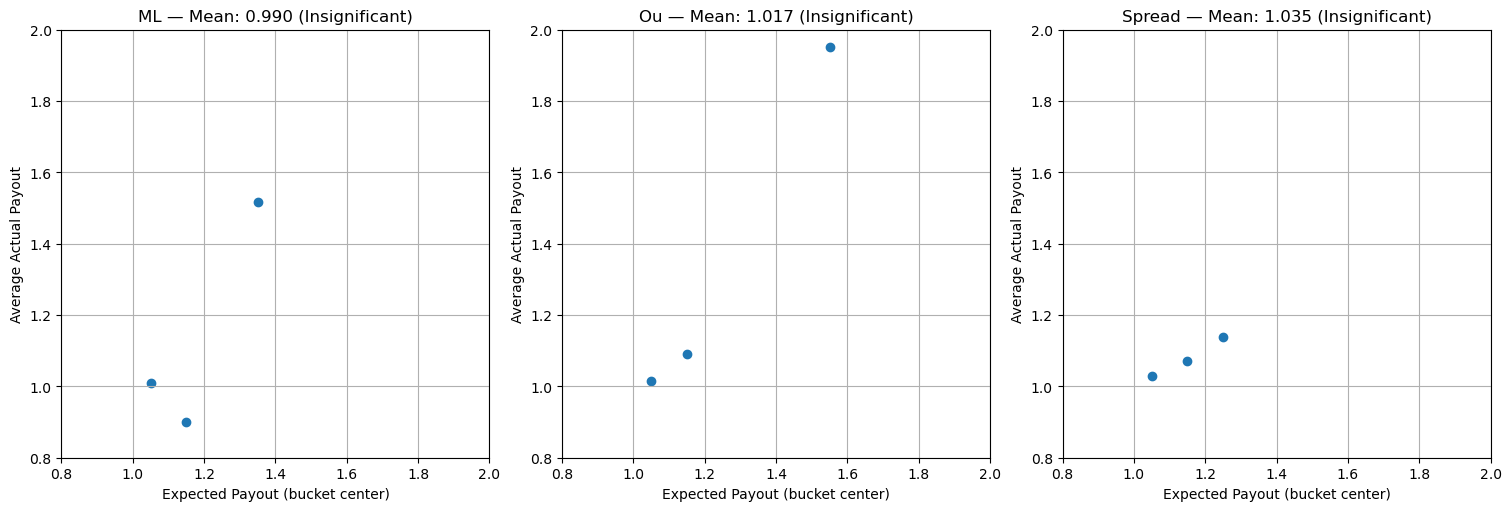

In [33]:
def plot_expected_vs_actual(bet_df, bucket_size=0.05, alpha=0.05):
    positive_ev_df = bet_df[bet_df['PositiveEV'] == 1].copy()

    bins = np.arange(
        positive_ev_df['ExpectedPayout'].min(),
        positive_ev_df['ExpectedPayout'].max() + bucket_size,
        bucket_size
    )
    labels = (bins[:-1] + bins[1:]) / 2

    bet_types = positive_ev_df['BetType'].unique()
    fig, axes = plt.subplots(1, len(bet_types), figsize=(5 * len(bet_types), 5), constrained_layout=True)

    if len(bet_types) == 1:
        axes = [axes]

    for ax, bet_type in zip(axes, bet_types):
        df_bt = positive_ev_df[positive_ev_df['BetType'] == bet_type].copy()
        df_bt['ExpectedPayoutBucket'] = pd.cut(df_bt['ExpectedPayout'], bins=bins, labels=labels, include_lowest=True)

        bucketed = df_bt.groupby('ExpectedPayoutBucket').agg(
            avg_actual_payout=('ActualPayout', 'mean')
        ).dropna()

        # Calculate overall average actual payout & t-test against 1
        actual_payouts = df_bt['ActualPayout'].dropna()
        actual_payouts = pd.to_numeric(actual_payouts, errors='coerce').dropna()

        
        mean_actual = actual_payouts.mean()
        if len(actual_payouts) > 1:
            t_stat, p_val = ttest_1samp(actual_payouts, popmean=1)
            significant = (p_val / 2 < alpha) and (t_stat > 0)
        else:
            significant = False

        signif_text = "Significant" if significant else "Insignificant"

        # Plot scatter
        ax.scatter(bucketed.index.astype(float), bucketed['avg_actual_payout'])
        ax.set_title(f'{bet_type} — Mean: {mean_actual:.3f} ({signif_text})')
        ax.set_xlabel('Expected Payout (bucket center)')
        ax.set_ylabel('Average Actual Payout')
        ax.set_xlim(0.8, 2)
        ax.set_ylim(0.8, 2)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True)

    plt.show()

# Example usage:
plot_expected_vs_actual(bet_df, bucket_size=0.1)


Interpretations:
- For ML bets, when I pick Vegas's favorite, I expect a payout of ExpectedPayout%. They actually received payouts of ActualPayout% across count bets.
- For Ou bets, when I pick the Under, I expect a payout of ExpectedPayout%. They actually received payouts of ActualPayout% across count bets.
- For Spread bets, when I pick a team that Vegas is neutral on (both have the same ML odds), I expect a payout of ExpectedPayout%. They actually received payouts of ActualPayout% across count bets.

##### 1C. Overall Actual Payout

In [34]:
bet_df[bet_df['PositiveEV'] == 1][['ExpectedPayout', 'ActualPayout']].agg('mean')

ExpectedPayout   1.068804
ActualPayout     1.013926
dtype: object

##### 1D. Predicted Cover Rates vs. Actual Cover Rates

In [35]:
bet_df[bet_df['BetResult'] != "Push"].groupby(['BetType', 'BetPick'])[['Cover', 'BetWin']].mean().reset_index()

,BetType,BetPick,Cover,BetWin
0,ML,Favorite,0.558560,0.567674
1,ML,Neither,0.500000,0.500000
2,ML,Underdog,0.441440,0.432326
3,Ou,Over,0.487220,0.476923
4,Ou,Under,0.458539,0.507692
5,Spread,Favorite,0.431795,0.433640
6,Spread,Neither,0.372340,0.372340
7,Spread,Underdog,0.568205,0.566360


Interpretations:
- For ML bets, when I pick Vegas's favorite, I expect them to cover Cover% of the time. That bet actually wins BetWin% of the time.
- For Ou bets, when I pick the over, I expect the over to cover Cover% of the time. That bet actually wins BetWin% of the time.
- For Spread bets, when I pick a team that Vegas is neutral on (both have the same ML odds), I expect them to cover Cover% of the time. That bet actual wins BetWin% of the time.

##### 1E. Favorite Accuracy

In [36]:
print(f"My favorites win {bet_df[(bet_df['BetType'] == 'ML') & (bet_df['ModelDog'] == 'Favorite')]['BetWin'].mean() * 100 :.1f}% of games")
print(f"Vegas's favorites win {bet_df[(bet_df['BetType'] == 'ML') & (bet_df['VegasDog'] == 'Favorite')]['BetWin'].mean() * 100 :.1f}% of games")

My favorites win 58.2% of games
Vegas's favorites win 56.8% of games


### Runs

##### 2A. Totals

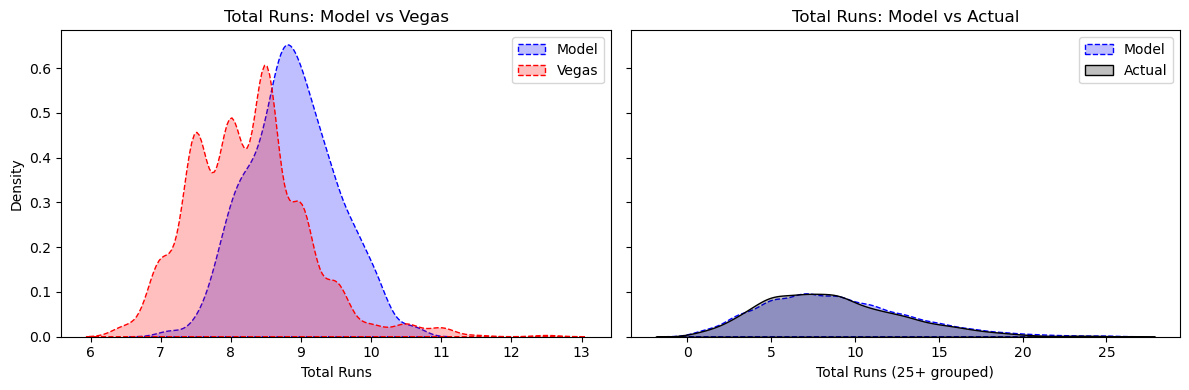

In [37]:
# Filter to valid rows where TotalCounts is a dict and needed columns exist
ml_df = bet_df[(bet_df['BetType'] == 'ML') & (bet_df['TotalCounts'].apply(lambda x: isinstance(x, dict)))].copy()

# Left plot data: continuous scores (Vegas vs Model)
vegas_scores = ml_df['OU'].dropna()
model_scores = ml_df['ModelTotalScore'].dropna()

# Right plot data: expand TotalCounts dicts into samples & actual TotalScore values
sim_samples = []
for d in ml_df['TotalCounts']:
    if not isinstance(d, dict) or len(d) == 0:
        continue
    for score, count in d.items():
        try:
            score_int = int(float(score))  # convert string/float keys safely
            binned_score = score_int if score_int < 25 else 25
            count_int = int(count)
            sim_samples.extend([binned_score] * count_int)
        except Exception as e:
            print(f"Skipping invalid entry: score={score}, count={count}, error={e}")


actual_samples = ml_df['TotalScore'].dropna().astype(int).apply(lambda x: x if x < 25 else 25).tolist()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Left plot: VegasTotalScore vs ModelTotalScore KDE
sns.kdeplot(model_scores, label='Model', shade=True, ax=axes[0], linestyle='--', color='blue')
sns.kdeplot(vegas_scores, label='Vegas', shade=True, ax=axes[0], linestyle='--', color='red')
axes[0].legend()
axes[0].set_title("Total Runs: Model vs Vegas")
axes[0].set_xlabel("Total Runs")

# Right plot: TotalCounts (sim) vs TotalScore (actual) KDE
sns.kdeplot(sim_samples, label='Model', shade=True, bw_adjust=3, ax=axes[1], linestyle='--', color='blue')
sns.kdeplot(actual_samples, label='Actual', shade=True, ax=axes[1], color='black')
axes[1].legend()
axes[1].set_title("Total Runs: Model vs Actual")
axes[1].set_xlabel("Total Runs (25+ grouped)")

plt.tight_layout()
plt.show()


In [38]:
print(f"Model MSE: {mean_squared_error(bet_df.drop_duplicates('game_id')[['ModelTotalScore', 'OU', 'TotalScore']].dropna()['TotalScore'], bet_df.drop_duplicates('game_id')[['ModelTotalScore', 'OU', 'TotalScore']].dropna()['ModelTotalScore']):.3f}")
print(f"Vegas MSE: {mean_squared_error(bet_df.drop_duplicates('game_id')[['ModelTotalScore', 'OU', 'TotalScore']].dropna()['TotalScore'], bet_df.drop_duplicates('game_id')[['ModelTotalScore', 'OU', 'TotalScore']].dropna()['OU']):.3f}")

Model MSE: 18.727
Vegas MSE: 17.762


##### 2B. Away/Home

Model Average Score

In [39]:
away_model_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['BetSide'] == "Away")]['ModelScore']
home_model_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['BetSide'] == "Home")]['ModelScore']

Vegas Score

In [40]:
away_vegas_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['BetSide'] == "Away")]['VegasScore']
home_vegas_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['BetSide'] == "Home")]['VegasScore']

Model Run Counts

In [41]:
# Step 1: Ensure Counts column is parsed as dicts
bet_df['Counts'] = bet_df['Counts'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 2: Filter for valid ML rows with proper dicts
ml_valid = bet_df[(bet_df['BetType'] == 'ML') & (bet_df['Counts'].apply(lambda x: isinstance(x, dict)))]

# Step 3: Separate filters
away_df = ml_valid[ml_valid['BetSide'] == 'Away']
home_df = ml_valid[ml_valid['BetSide'] == 'Home']

# Step 4: Sum counts into separate dictionaries
away_model_counts_dict = Counter()
for d in away_df['Counts']:
    away_model_counts_dict.update(d)

home_model_counts_dict = Counter()
for d in home_df['Counts']:
    home_model_counts_dict.update(d)

Actual Runs

In [42]:
away_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['BetSide'] == "Away")]['Score']
home_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['BetSide'] == "Home")]['Score']

Graph

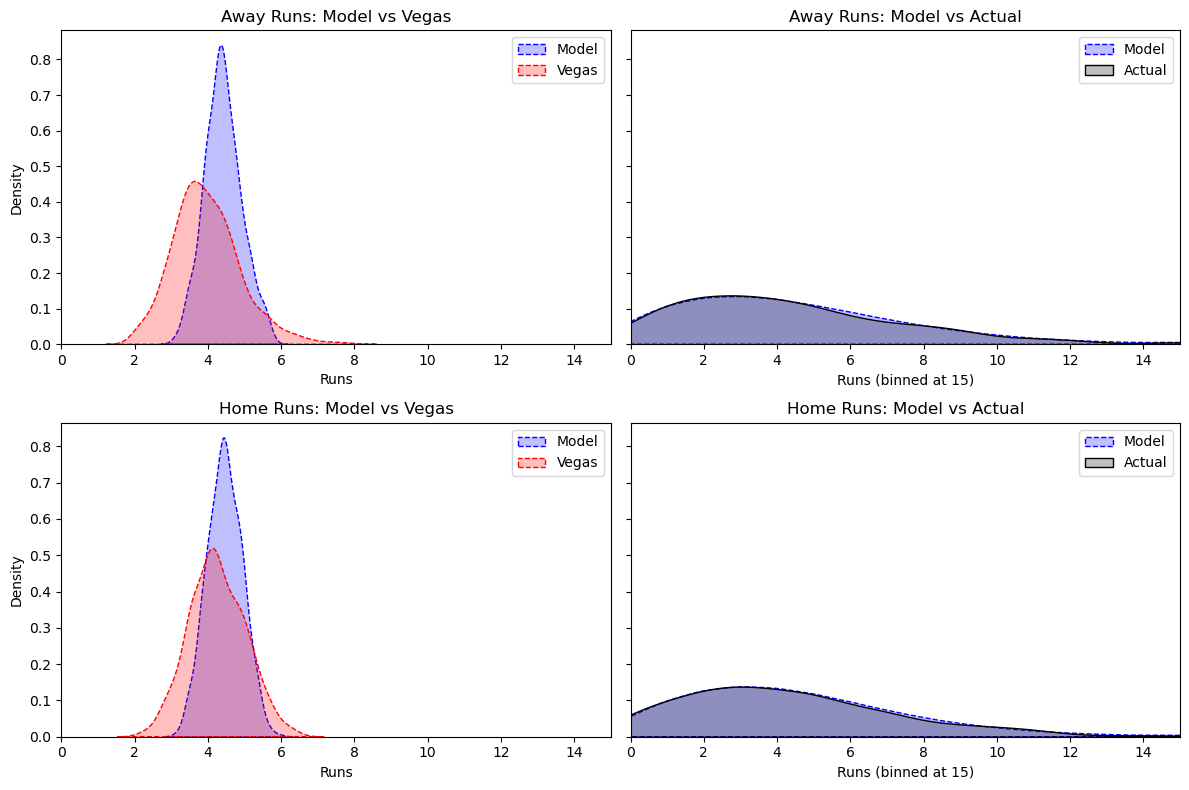

In [43]:
max_bin = 15

# Prepare samples helper
def prepare_samples(counts_dict, max_bin):
    samples = []
    for score, count in counts_dict.items():
        binned_score = score if score <= max_bin else max_bin
        samples.extend([binned_score] * count)
    return samples

# Filter ML + valid dict counts
ml_valid = bet_df[(bet_df['BetType'] == 'ML') & (bet_df['Counts'].apply(lambda x: isinstance(x, dict)))]

away_df = ml_valid[ml_valid['BetSide'] == 'Away']
home_df = ml_valid[ml_valid['BetSide'] == 'Home']

# Sum counts into dictionaries
away_model_counts_dict = Counter()
for d in away_df['Counts']:
    away_model_counts_dict.update(d)

home_model_counts_dict = Counter()
for d in home_df['Counts']:
    home_model_counts_dict.update(d)

# Use your already defined vegas and model scores
away_vegas_score = away_df['VegasScore'].dropna()
away_model_score = away_df['ModelScore'].dropna()

home_vegas_score = home_df['VegasScore'].dropna()
home_model_score = home_df['ModelScore'].dropna()

# Right column: expand counts dict to samples
away_model_samples = prepare_samples(away_model_counts_dict, max_bin)
home_model_samples = prepare_samples(home_model_counts_dict, max_bin)

# Actual scores clipped at max_bin
away_actual_scores = away_score.apply(lambda x: x if x <= max_bin else max_bin).dropna().astype(int).tolist()
home_actual_scores = home_score.apply(lambda x: x if x <= max_bin else max_bin).dropna().astype(int).tolist()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey='row')

# Top-left: Away ModelScore vs Away VegasScore
sns.kdeplot(away_model_score, label='Model', shade=True, ax=axes[0, 0], linestyle='--', color='blue')
sns.kdeplot(away_vegas_score, label='Vegas', shade=True, ax=axes[0, 0], linestyle='--', color='red')
axes[0, 0].legend()
axes[0, 0].set_title("Away Runs: Model vs Vegas")
axes[0, 0].set_xlim(0, max_bin)
axes[0, 0].set_xlabel("Runs")

# Bottom-left: Home ModelScore vs Home VegasScore
sns.kdeplot(home_model_score, label='Model', shade=True, ax=axes[1, 0], linestyle='--', color='blue')
sns.kdeplot(home_vegas_score, label='Vegas', shade=True, ax=axes[1, 0], linestyle='--',  color='red')
axes[1, 0].legend()
axes[1, 0].set_title("Home Runs: Model vs Vegas")
axes[1, 0].set_xlim(0, max_bin)
axes[1, 0].set_xlabel("Runs")

# Top-right: Away Model Counts dict vs Away Actual Score
sns.kdeplot(away_model_samples, label='Model', shade=True, bw_adjust=3, ax=axes[0, 1], linestyle='--', color='blue')
sns.kdeplot(away_actual_scores, label='Actual', shade=True, ax=axes[0, 1], color='black')
axes[0, 1].legend()
axes[0, 1].set_title("Away Runs: Model vs Actual")
axes[0, 1].set_xlim(0, max_bin)
axes[0, 1].set_xlabel("Runs (binned at 15)")

# Bottom-right: Home Model Counts dict vs Home Actual Score
sns.kdeplot(home_model_samples, label='Model', shade=True, bw_adjust=3, ax=axes[1, 1], linestyle='--', color='blue')
sns.kdeplot(home_actual_scores, label='Actual', shade=True, ax=axes[1, 1], color='black')
axes[1, 1].legend()
axes[1, 1].set_title("Home Runs: Model vs Actual")
axes[1, 1].set_xlim(0, max_bin)
axes[1, 1].set_xlabel("Runs (binned at 15)")

plt.tight_layout()
plt.show()


In [44]:
print(f"Away Model MSE: {mean_squared_error(bet_df[(bet_df['BetType'] == 'ML') & (bet_df['BetSide'] == 'Away')][['away_score', 'ModelScore', 'VegasScore']].dropna()['ModelScore'], bet_df[(bet_df['BetType'] == 'ML') & (bet_df['BetSide'] == 'Away')][['away_score', 'ModelScore', 'VegasScore']].dropna()['away_score'])}")
print(f"Away Vegas MSE: {mean_squared_error(bet_df[(bet_df['BetType'] == 'ML') & (bet_df['BetSide'] == 'Away')][['away_score', 'ModelScore', 'VegasScore']].dropna()['VegasScore'], bet_df[(bet_df['BetType'] == 'ML') & (bet_df['BetSide'] == 'Away')][['away_score', 'ModelScore', 'VegasScore']].dropna()['away_score'])}")
print(f"Home Model MSE: {mean_squared_error(bet_df[(bet_df['BetType'] == 'ML') & (bet_df['BetSide'] == 'Home')][['home_score', 'ModelScore', 'VegasScore']].dropna()['ModelScore'], bet_df[(bet_df['BetType'] == 'ML') & (bet_df['BetSide'] == 'Home')][['home_score', 'ModelScore', 'VegasScore']].dropna()['home_score'])}")
print(f"Home Vegas MSE: {mean_squared_error(bet_df[(bet_df['BetType'] == 'ML') & (bet_df['BetSide'] == 'Home')][['home_score', 'ModelScore', 'VegasScore']].dropna()['VegasScore'], bet_df[(bet_df['BetType'] == 'ML') & (bet_df['BetSide'] == 'Home')][['home_score', 'ModelScore', 'VegasScore']].dropna()['home_score'])}")

Away Model MSE: 9.268563453532643
Away Vegas MSE: 9.527771657008042
Home Model MSE: 8.729286076255917
Home Vegas MSE: 8.865554583395019


##### 2C. Underdog/Favorite

Model Average Score

In [45]:
underdog_model_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['ModelDog'] == "Underdog")]['ModelScore']
favorite_model_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['ModelDog'] == "Favorite")]['ModelScore']

Vegas Score

In [46]:
underdog_vegas_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['VegasDog'] == "Underdog")]['VegasScore']
favorite_vegas_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['VegasDog'] == "Favorite")]['VegasScore']

Model Run Counts

In [47]:
# Step 1: Ensure Counts column is parsed as dicts
bet_df['Counts'] = bet_df['Counts'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 2: Filter for valid ML rows with proper dicts
ml_valid = bet_df[(bet_df['BetType'] == 'ML') & (bet_df['Counts'].apply(lambda x: isinstance(x, dict)))]

# Step 3: Separate filters
underdog_df = ml_valid[ml_valid['ModelDog'] == 'Underdog']
favorite_df = ml_valid[ml_valid['ModelDog'] == 'Favorite']

# Step 4: Sum counts into separate dictionaries
underdog_model_counts_dict = Counter()
for d in away_df['Counts']:
    underdog_model_counts_dict.update(d)

favorite_model_counts_dict = Counter()
for d in home_df['Counts']:
    favorite_model_counts_dict.update(d)

Actual Runs

In [48]:
underdog_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['ModelDog'] == "Underdog")]['Score']
favorite_score = bet_df[(bet_df['BetType'] == "ML") & (bet_df['ModelDog'] == "Favorite")]['Score']

Graph

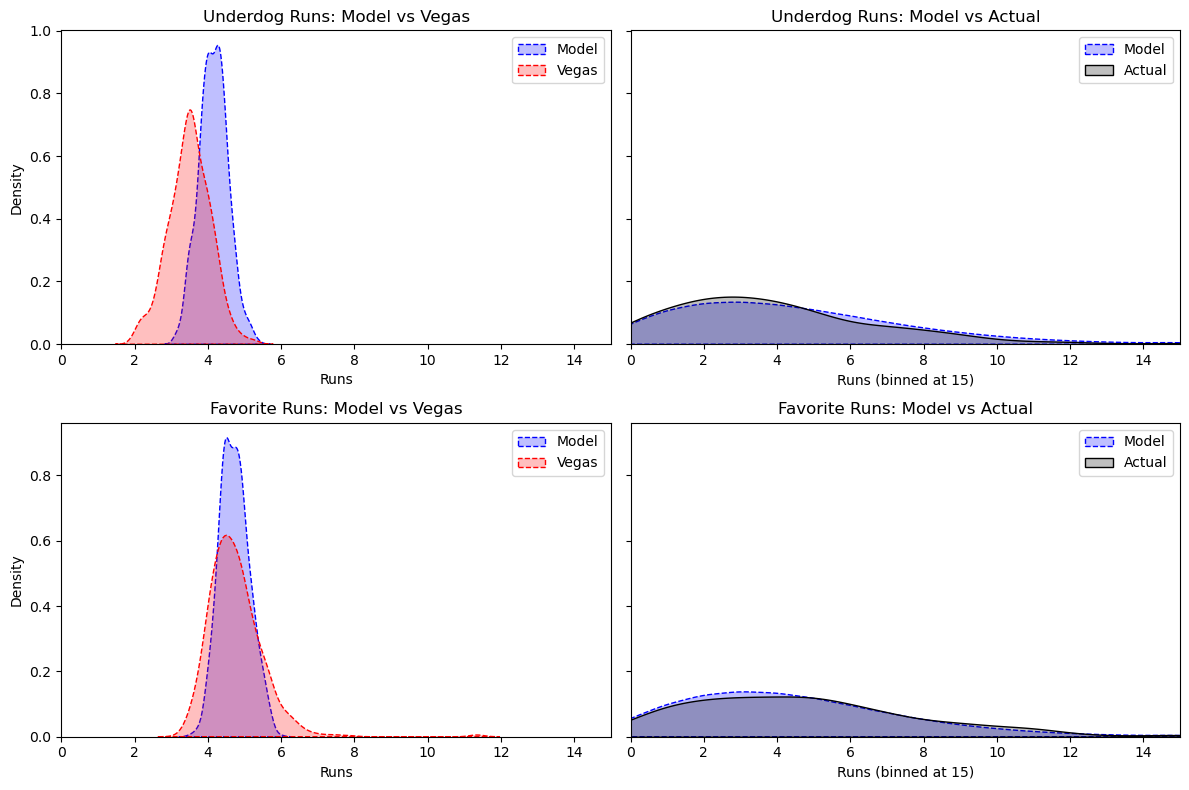

In [49]:
max_bin = 15

# Helper function for expanding counts dict to samples (reuse)
def prepare_samples(counts_dict, max_bin):
    samples = []
    for score, count in counts_dict.items():
        binned_score = score if score <= max_bin else max_bin
        samples.extend([binned_score] * count)
    return samples

# Expand counts dicts into sample lists
underdog_model_samples = prepare_samples(underdog_model_counts_dict, max_bin)
favorite_model_samples = prepare_samples(favorite_model_counts_dict, max_bin)

# Actual scores clipped at max_bin
underdog_actual_scores = underdog_score.apply(lambda x: x if x <= max_bin else max_bin).dropna().astype(int).tolist()
favorite_actual_scores = favorite_score.apply(lambda x: x if x <= max_bin else max_bin).dropna().astype(int).tolist()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey='row')

# Top-left: Underdog ModelScore vs Underdog VegasScore
sns.kdeplot(underdog_model_score, label='Model', shade=True, ax=axes[0, 0], linestyle='--', color='blue')
sns.kdeplot(underdog_vegas_score, label='Vegas', shade=True, ax=axes[0, 0], linestyle='--', color='red')
axes[0, 0].legend()
axes[0, 0].set_title("Underdog Runs: Model vs Vegas")
axes[0, 0].set_xlim(0, max_bin)
axes[0, 0].set_xlabel("Runs")

# Bottom-left: Favorite ModelScore vs Favorite VegasScore
sns.kdeplot(favorite_model_score, label='Model', shade=True, ax=axes[1, 0], linestyle='--', color='blue')
sns.kdeplot(favorite_vegas_score, label='Vegas', shade=True, ax=axes[1, 0], linestyle='--', color='red')
axes[1, 0].legend()
axes[1, 0].set_title("Favorite Runs: Model vs Vegas")
axes[1, 0].set_xlim(0, max_bin)
axes[1, 0].set_xlabel("Runs")

# Top-right: Underdog Model Counts dict vs Underdog Actual Score
sns.kdeplot(underdog_model_samples, label='Model', shade=True, bw_adjust=3, ax=axes[0, 1], linestyle='--', color='blue')
sns.kdeplot(underdog_actual_scores, label='Actual', shade=True, ax=axes[0, 1], color='black')
axes[0, 1].legend()
axes[0, 1].set_title("Underdog Runs: Model vs Actual")
axes[0, 1].set_xlim(0, max_bin)
axes[0, 1].set_xlabel("Runs (binned at 15)")

# Bottom-right: Favorite Model Counts dict vs Favorite Actual Score
sns.kdeplot(favorite_model_samples, label='Model', shade=True, bw_adjust=3, ax=axes[1, 1], linestyle='--', color='blue')
sns.kdeplot(favorite_actual_scores, label='Actual', shade=True, ax=axes[1, 1], color='black')
axes[1, 1].legend()
axes[1, 1].set_title("Favorite Runs: Model vs Actual")
axes[1, 1].set_xlim(0, max_bin)
axes[1, 1].set_xlabel("Runs (binned at 15)")

plt.tight_layout()
plt.show()

In [50]:
print(f"Underdog Model MSE: {mean_squared_error(bet_df[(bet_df['BetType'] == 'ML') & (bet_df['ModelDog'] == 'Underdog')][['Score', 'ModelScore', 'VegasScore']].dropna()['ModelScore'], bet_df[(bet_df['BetType'] == 'ML') & (bet_df['ModelDog'] == 'Underdog')][['Score', 'ModelScore', 'VegasScore']].dropna()['Score'])}")
print(f"Underdog Vegas MSE: {mean_squared_error(bet_df[(bet_df['BetType'] == 'ML') & (bet_df['VegasDog'] == 'Underdog')][['Score', 'ModelScore', 'VegasScore']].dropna()['VegasScore'], bet_df[(bet_df['BetType'] == 'ML') & (bet_df['VegasDog'] == 'Underdog')][['Score', 'ModelScore', 'VegasScore']].dropna()['Score'])}")
print(f"Favorite Model MSE: {mean_squared_error(bet_df[(bet_df['BetType'] == 'ML') & (bet_df['ModelDog'] == 'Favorite')][['Score', 'ModelScore', 'VegasScore']].dropna()['ModelScore'], bet_df[(bet_df['BetType'] == 'ML') & (bet_df['ModelDog'] == 'Favorite')][['Score', 'ModelScore', 'VegasScore']].dropna()['Score'])}")
print(f"Favorite Vegas MSE: {mean_squared_error(bet_df[(bet_df['BetType'] == 'ML') & (bet_df['VegasDog'] == 'Favorite')][['Score', 'ModelScore', 'VegasScore']].dropna()['VegasScore'], bet_df[(bet_df['BetType'] == 'ML') & (bet_df['VegasDog'] == 'Favorite')][['Score', 'ModelScore', 'VegasScore']].dropna()['Score'])}")

Underdog Model MSE: 8.138966346922622
Underdog Vegas MSE: 8.863937161753189
Favorite Model MSE: 9.894510266207357
Favorite Vegas MSE: 9.53698672876453


##### 2D. Victory Margin

Model Margin

In [51]:
bet_df['ModelMargin'] = abs(bet_df['ModelScore1'] - bet_df['ModelScore2'])
model_margin = bet_df.drop_duplicates(subset=['game_id'], keep='first')['ModelMargin']

Vegas Margin

In [52]:
bet_df['VegasMargin'] = abs(bet_df['VegasScore1'] - bet_df['VegasScore2'])
vegas_margin = bet_df.drop_duplicates('game_id', keep='first')['VegasMargin'].dropna()

Model Counts

In [53]:
# Step 1: Ensure MarginCounts column is parsed as dicts
bet_df['MarginCounts'] = bet_df['MarginCounts'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 2: Filter only valid dict rows
valid_margin_df = bet_df.drop_duplicates('game_id', keep='first')[bet_df['MarginCounts'].apply(lambda x: isinstance(x, dict))]

# Step 3: Sum all MarginCounts into one dictionary
margin_counts_dict = Counter()
for d in valid_margin_df['MarginCounts']:
    margin_counts_dict.update(d)

Actual Margin

In [54]:
bet_df['Margin'] = abs(bet_df['away_score'] - bet_df['home_score'])
actual_margin = bet_df['Margin']

Margin Table

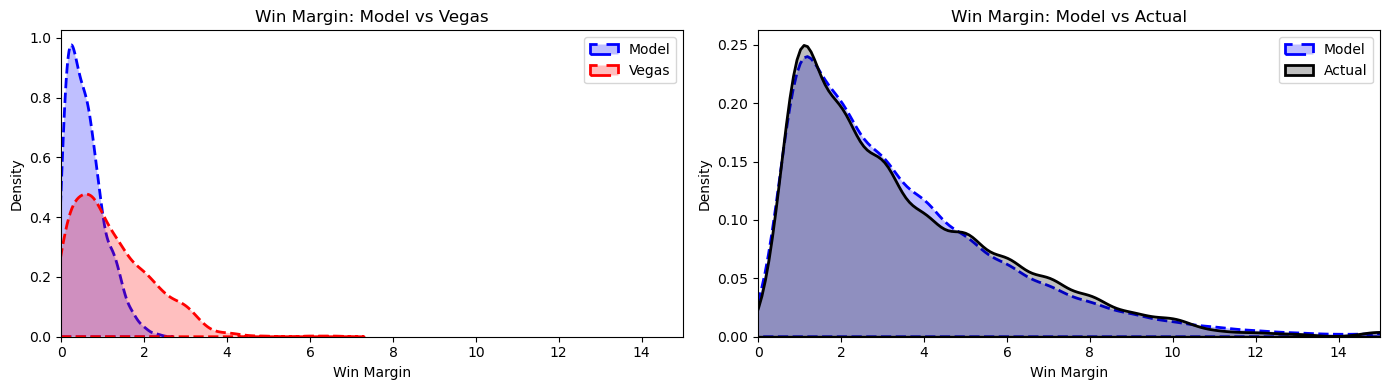

In [55]:
# Settings
max_bin = 15

# Expand counts dict into sample list, capping values at max_bin
def expand_positive_counts(counts_dict, max_bin):
    samples = []
    for margin, count in counts_dict.items():
        binned = margin if margin <= max_bin else max_bin
        samples.extend([binned] * count)
    return samples

# Prepare model vs actual samples
sim_samples = expand_positive_counts(margin_counts_dict, max_bin)
actual_binned = [m if m <= max_bin else max_bin for m in actual_margin]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Model vs Vegas (KDE)
sns.kdeplot(model_margin, label='Model', shade=True, ax=axes[0], color='blue', linestyle='--', linewidth=2)
sns.kdeplot(vegas_margin, label='Vegas', shade=True, ax=axes[0], color='red', linestyle='--', linewidth=2)
axes[0].legend()
axes[0].set_title("Win Margin: Model vs Vegas")
axes[0].set_xlabel("Win Margin")
axes[0].set_xlim(0, max_bin)

# Right: Simulated vs Actual (KDE)
sns.kdeplot(sim_samples, label='Model', shade=True, ax=axes[1], color='blue', bw_adjust=3, linestyle='--', linewidth=2)
sns.kdeplot(actual_binned, label='Actual', shade=True, ax=axes[1], color='black', bw_adjust=1, linewidth=2)
axes[1].legend()
axes[1].set_title("Win Margin: Model vs Actual")
axes[1].set_xlabel("Win Margin")
axes[1].set_xlim(0, max_bin)

plt.tight_layout()
plt.show()

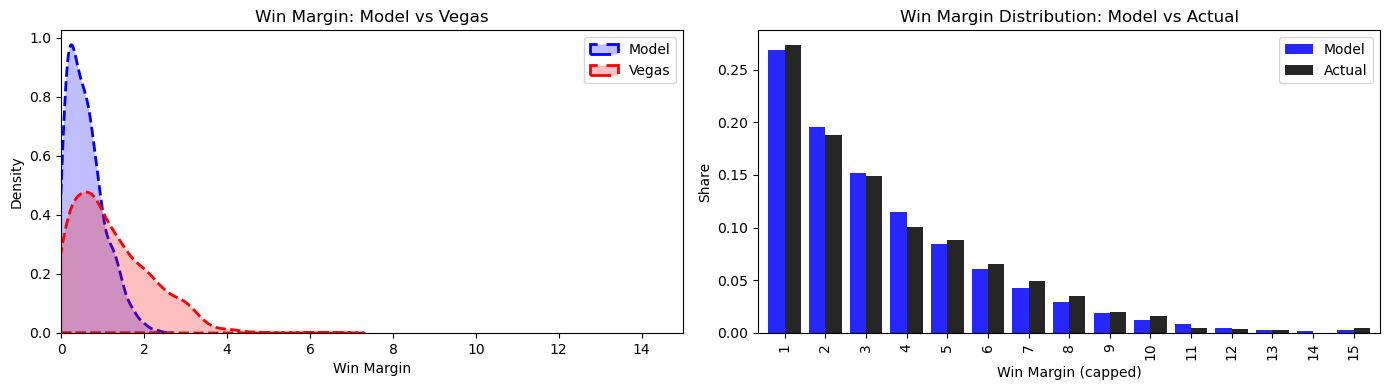

In [56]:
# Compute normalized value counts
sim_vc = pd.Series(sim_samples).value_counts(normalize=True)
actual_vc = pd.Series(actual_binned).value_counts(normalize=True)

# Align index
all_index = sim_vc.index.union(actual_vc.index)

df_plot = pd.DataFrame({
    'Model': sim_vc.reindex(all_index, fill_value=0),
    'Actual': actual_vc.reindex(all_index, fill_value=0),
}).sort_index()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Model vs Vegas (KDE)
sns.kdeplot(model_margin, label='Model', shade=True, ax=axes[0], color='blue', linestyle='--', linewidth=2)
sns.kdeplot(vegas_margin, label='Vegas', shade=True, ax=axes[0], color='red', linestyle='--', linewidth=2)
axes[0].legend()
axes[0].set_title("Win Margin: Model vs Vegas")
axes[0].set_xlabel("Win Margin")
axes[0].set_xlim(0, max_bin)

# Right: Simulated vs Actual (Bar Chart)
df_plot.plot(
    kind='bar',
    ax=axes[1],
    width=0.8,
    alpha=0.85,
    color=['blue', 'black']   # Sim = blue, Actual = black

)

axes[1].set_title("Win Margin Distribution: Model vs Actual")
axes[1].set_xlabel("Win Margin (capped)")
axes[1].set_ylabel("Share")
axes[1].legend()

plt.tight_layout()
plt.show()


In [57]:
sim_vc = pd.Series(sim_samples).value_counts(normalize=True)
actual_vc = pd.Series(actual_margin).value_counts(normalize=True)

all_index = sim_vc.index.union(actual_vc.index)

pd.DataFrame({
    'Sim': sim_vc.reindex(all_index, fill_value=0),
    'Actual': actual_vc.reindex(all_index, fill_value=0),
}).sort_index()


,Sim,Actual
1,0.268767,0.273515
2,0.195824,0.188119
3,0.151337,0.148515
4,0.115160,0.100248
5,0.084211,0.087871
6,0.060664,0.065594
7,0.042797,0.049505
8,0.028977,0.034653
9,0.019122,0.019802
10,0.012440,0.016089


##### 2E. Time

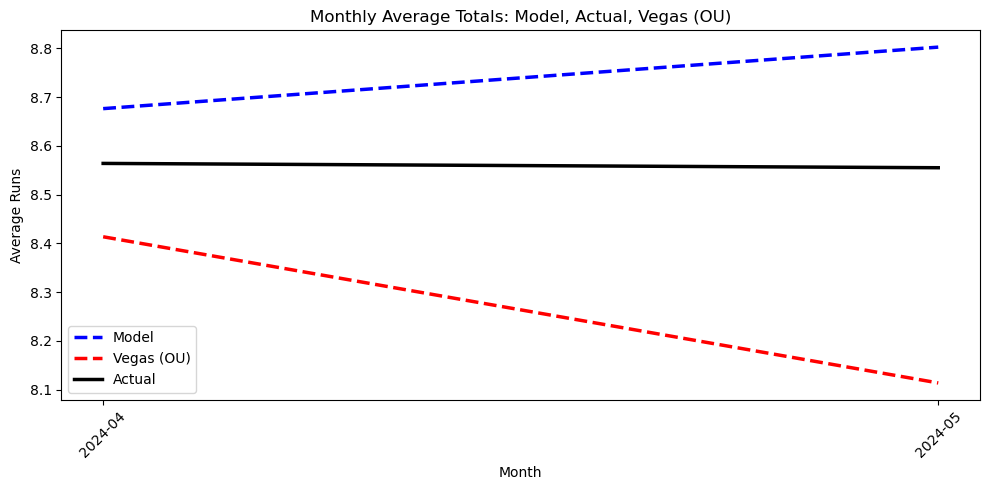

In [58]:
# Step 1: Drop duplicates on game_id
bet_unique = bet_df.drop_duplicates(subset='game_id').copy()

# Step 2: Ensure game_datetime is a datetime object and extract year-month
bet_unique['game_datetime'] = pd.to_datetime(bet_unique['game_datetime'])
bet_unique['YearMonth'] = bet_unique['game_datetime'].dt.to_period('M')

# Step 3: Filter for April 2024 and later
bet_filtered = bet_unique[bet_unique['YearMonth'] >= '2024-04']

# Step 4: Group by month and compute averages
monthly_avg = bet_filtered.groupby('YearMonth')[['ModelTotalScore', 'TotalScore', 'OU']].mean().reset_index()
monthly_avg['YearMonth'] = monthly_avg['YearMonth'].astype(str)  # for plotting

# Step 5: Plotting with custom styles
plt.figure(figsize=(10, 5))

# Plot with specific colors and line styles
plt.plot(monthly_avg['YearMonth'], monthly_avg['ModelTotalScore'], label='Model', color='blue', linestyle='--', lw=2.5)
plt.plot(monthly_avg['OU'], label='Vegas (OU)', color='red', linestyle='--', lw=2.5)
plt.plot(monthly_avg['YearMonth'], monthly_avg['TotalScore'], label='Actual', color='black', linestyle='-', lw=2.5)  # solid line

plt.xticks(rotation=45)
plt.title("Monthly Average Totals: Model, Actual, Vegas (OU)")
plt.xlabel("Month")
plt.ylabel("Average Runs")
plt.legend()
plt.tight_layout()
plt.show()

##### 2F. Venue

In [59]:
# Drop duplicate games first
unique_games = bet_df.drop_duplicates(subset=['game_id'])

# Group by venue and aggregate
agg_df = unique_games.groupby(['venue_id', 'venue_name']).agg(
    ModelTotalScore=('ModelTotalScore', 'mean'),
    TotalScore=('TotalScore', 'mean'),
    OU=('OU', 'mean'),
    count=('game_id', 'count')
).reset_index()

# Filter venues with more than 10 observations
agg_df_filtered = agg_df[agg_df['count'] > 10].copy()

# Calculate difference
agg_df_filtered['Diff'] = agg_df_filtered['ModelTotalScore'] - agg_df_filtered['TotalScore']

# Your color function (unchanged)
def color_diff(val):
    max_val = 2  # fixed range from -2 to 2
    percent = min(abs(val) / max_val, 1) * 50  # cap at 1 to avoid overflow

    if val > 0:
        return f"""
            background: linear-gradient(to right, transparent 50%, red 50%, red {50 + percent}%, transparent {50 + percent}%);
            color: black;
        """
    elif val < 0:
        return f"""
            background: linear-gradient(to left, transparent 50%, blue 50%, blue {50 + percent}%, transparent {50 + percent}%);
            color: black;
        """
    else:
        return ''



# Apply styling to the filtered DataFrame
styled = agg_df_filtered.style.applymap(color_diff, subset=['Diff'])


print(f"Bias: {agg_df_filtered['Diff'].mean()}")
print(f"MSE: {((agg_df_filtered['Diff'])**2).mean()}")

styled

Bias: 0.11614148434587385
MSE: 0.5844847205100637


,venue_id,venue_name,ModelTotalScore,TotalScore,OU,count,Diff
0,1,Angel Stadium,9.171706,10.240000,8.300000,25,-1.068294
1,2,Oriole Park at Camden Yards,8.721903,8.857143,8.071429,28,-0.135240
2,3,Fenway Park,8.935325,8.307692,8.653846,26,0.627633
3,4,Guaranteed Rate Field,8.123597,7.724138,8.137931,29,0.399459
4,5,Progressive Field,8.712508,8.875000,7.956522,24,-0.162492
5,7,Kauffman Stadium,9.757150,8.931034,8.482759,29,0.826115
6,10,Oakland Coliseum,8.695710,9.551724,7.807692,29,-0.856014
7,12,Tropicana Field,8.040210,8.875000,7.935484,32,-0.834790
8,14,Rogers Centre,8.654803,8.375000,8.020833,24,0.279803
9,15,Chase Field,9.597364,9.464286,8.888889,28,0.133078


In [60]:
all_filename, all_adjusted_filename

('predict_all_1688040_72620_20251121',
 'predict_all_adjusted_16_73434_20251115.sav')

In [61]:
!jupyter nbconvert --to html "E01. Evaluate Games.ipynb" \
  --output="E01. Evaluate Games {datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.html" \
  --output-dir="{os.path.join(baseball_path, 'E01. Evaluate Games')}"

[NbConvertApp] Converting notebook E01. Evaluate Games.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 1084643 bytes to C:\Users\james\Documents\MLB\Database\E01. Evaluate Games\E01. Evaluate Games 2025-11-22_07-33-55.html
